# Predicting game popularity with iOS App Store data: game descriptions
Andrea Lee (last update: March 30, 2020)

# Motivation

Mobile game market is one of the most competitive markets to break into; according to Apptopia's analysis, top 50 grossing iOS mobile games in the US accounted for 76% of the total revenue in 2017. In addition, a game stays only about 30 days within the top 50 grossing ranks (https://blog.apptopia.com/apple-grossing-ranks). This market is extremely difficult for small developers like Game Revenant, despite the production of a high-quality mobile game. Game Revenant's main mobile game, Where Shadows Slumber (WSS), has been featured multiple times and reviewed positively; however, the number of ratings and sales did not meet the hype that was shown by the free version of WSS.

One of the potential reasons maybe that the game is simply not visible to users because it is not optimized for app searches. As App Rader has identified, including keywords in the app title and description can increase the app search ranking that can potentially lead to increase in sales (https://appradar.com/blog/app-store-optimization-for-games/).

Thus, the goal of the project is to identify keywords in descriptions used by top games in iOS App Store and engineer new features to predict game popularity by using number of ratings as a target metric. Other features such as game genre, number of reviews, distribution of scores, languages available, and age rating were included in the predictive modeling. Based on the model, we can make additional business recommendations for small developers.

Note that this is an extension of an original project that was done by Vincent Sayseng, and please see the original repository for web scraping and original motivation: https://github.com/vin-say/Where-Shadows-Slumber. Some relevant comments and analyses from the original project were left throughout the project.

Where Shadows Slumber(WSS) is available here: https://apps.apple.com/us/app/where-shadows-slumber/id1221749074.

# Creating Database
## Assumptions

Profiles of games on the App Store were scraped using the package Scrapy and the scraping code can be found in the original project: https://github.com/vin-say/web-scraping/tree/master/iosgames. 
- Game profiles were stored in a SQLite database, in a table named after the genre section they were scrapped from.
- Game can appear in multiple genre sections.
- Regression model will be designed to predict a game's popularity based on features listed in the App Store game profiles. Since the App Store does not report the number of downloads directly, the number of review will be used as a surrogate target metric.
- Mean square error will be used as a major parameter, considering the vast number of outliers identified by the original project.
- Database was scraped from the US iOS App Store on October 2019 and only represents data at the time of data gathering.


## Preliminary Data Exploration

In [22]:

import pandas as pd
import sqlalchemy as sa
from pathlib import Path
from sqlalchemy import create_engine
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# Assumes that you have the database saved in a SQLite database from a previous project
e = sa.create_engine(r'sqlite:///D:\Program_practices\IOS\app-store.sqlite')
query = '''
        SELECT *, 'action' AS genre FROM iosaction UNION
        SELECT *, 'adventure' FROM iosadventure UNION
        SELECT *, 'board' FROM iosboard UNION
        SELECT *, 'card' FROM ioscard UNION 
        SELECT *, 'casino' FROM ioscasino UNION
        SELECT *, 'casual' FROM ioscasual UNION
        SELECT *, 'family' FROM iosfamily UNION
        SELECT *, 'music' FROM iosmusic UNION
        SELECT *, 'puzzle' FROM iospuzzle UNION
        SELECT *, 'racing' FROM iosracing UNION
        SELECT *, 'rpg' FROM iosrpg UNION
        SELECT *, 'simulation' FROM iossimulation UNION
        SELECT *, 'sports' FROM iossports UNION 
        SELECT *, 'strategy'FROM iosstrategy UNION 
        SELECT *, 'trivia' FROM iostrivia UNION
        SELECT *, 'word' FROM iosword
        '''
apps = pd.read_sql_query(query, e)
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380969 entries, 0 to 380968
Data columns (total 20 columns):
age          380969 non-null object
age_copy     380969 non-null object
author       380690 non-null object
category     380969 non-null object
compat       380969 non-null object
desc         380969 non-null object
editor       1384 non-null object
iap          148075 non-null object
lang         380969 non-null object
list_rank    11006 non-null object
nrating      234417 non-null object
price        380896 non-null object
score        234417 non-null object
seller       380969 non-null object
size         380969 non-null object
stars        234417 non-null object
subtitle     121114 non-null object
support      380969 non-null object
title        380969 non-null object
genre        380969 non-null object
dtypes: object(20)
memory usage: 58.1+ MB


In [4]:
#Data needs to be cleaned and coded; additionally, descriptions need to be processed using natural language processing techniques
apps.head()

,age,age_copy,author,category,compat,desc,editor,iap,lang,list_rank,nrating,price,score,seller,size,stars,subtitle,support,title,genre
0,12+,"""Media5 Interactive"" LLC,479.4 MB,,,,,,,Rated ...","""Media5 Interactive"" LLC",Games,Requires iOS 8.0 or later. Compatible with iPh...,The game allows you to develop and perfect a s...,None,Offers In-App Purchases,English,None,1 Rating,Free,2.0,"""Media5 Interactive"" LLC",479.4 MB,"width: 0%;,width: 0%;,width: 0%;,width: 100%;,...",None,"Game Center,Family Sharing",Sniper Shooting Champion,simulation
1,12+,"""Media5 Interactive"" LLC,479.4 MB,,,,,,,Rated ...","""Media5 Interactive"" LLC",Games,Requires iOS 8.0 or later. Compatible with iPh...,The game allows you to develop and perfect a s...,None,Offers In-App Purchases,English,None,1 Rating,Free,2.0,"""Media5 Interactive"" LLC",479.4 MB,"width: 0%;,width: 0%;,width: 0%;,width: 100%;,...",None,"Game Center,Family Sharing",Sniper Shooting Champion,sports
2,12+,"""Media5 Interactive"" LLC,78.2 MB,,,,,,,Rated 1...","""Media5 Interactive"" LLC",Games,Requires iOS 6.0 or later. Compatible with iPh...,The most stunning flail fighting game ever - R...,None,Offers In-App Purchases,English,None,None,Free,None,"""Media5 Interactive"" LLC",78.2 MB,None,None,"Game Center,Family Sharing",Flail Ramble Boom,action
3,12+,"""Media5 Interactive"" LLC,78.2 MB,,,,,,,Rated 1...","""Media5 Interactive"" LLC",Games,Requires iOS 6.0 or later. Compatible with iPh...,The most stunning flail fighting game ever - R...,None,Offers In-App Purchases,English,None,None,Free,None,"""Media5 Interactive"" LLC",78.2 MB,None,None,"Game Center,Family Sharing",Flail Ramble Boom,sports
4,12+,". Salim Ullah,96.8 MB,,,,,,,Rated 12+ for the ...",. Salim Ullah,Games,Requires iOS 8.0 or later. Compatible with iPh...,If your looking for a high quality gun applica...,None,None,English,None,2 Ratings,Free,1.0,. Salim Ullah,96.8 MB,"width: 0%;,width: 0%;,width: 0%;,width: 0%;,wi...",None,Family Sharing,Guns Simulator 3D,action


## Data Cleaning
Each feature is defined and described in the code cell below; processing required to organize the raw data into numerical and categorical variables. Cleaning can take some time, so the formatted data set is saved into a database at the end. The data cleaning process is almost identical to the original project except for the game descriptions.

In [5]:
import re

# age (categorical)
# Age rating for game. Dummy encoded.
# Categories are 4+, 9+, 12+, 17+

age_encoded = pd.get_dummies(apps['age'])
age_encoded.columns = ['age_' + col.replace('+','') for col in age_encoded.columns]
apps = pd.concat([apps, age_encoded], axis=1)
apps = apps.drop(columns=['age'])

# age_copy (str)
# Long string containing a variety information, including age rating, memory size, copyright information. 
# Was initially scraped to get the copyright year, to give estimate of release date. 
# Copyright year is not included frequently enough, however, so this category was dropped

apps = apps.drop(columns=['age_copy'])

# author (str)
# Author of game. Can be used to consolidate duplicate game titles

# category (categorical)
# Category of app. Data was scrapped from game storefront, so everything should be listed as 'Games'
# There are a few cases where this was not true (e.g. classified as 'Education', or 'Music')
# Only concerned with game releases, so we filter for these specifically

apps = apps[apps['category'] == 'Games']
apps = apps.drop(columns=['category'])

# compat (ordinal)
# Compatibility of the app. Interested primarily in the minimum OS release requirements. 
# There are 409 different OS version releases (including minor releases), so we confine our search to major software versions

# Very few cases don't contain compatibility information; filter these out
apps = apps.dropna(subset=['compat']) 
# All version requirements starts with the phrase, 'Requires iOS x.x. or later'. First filter for that phrase
apps['compat'] = apps['compat'].apply(lambda compat: re.findall(r'Requires\siOS\s\d+', compat)) 
# Pull out just the major iOS release version. 
apps['compat'] = apps['compat'].apply(lambda compat: int(re.findall(r'\d+', compat[0])[0]) if compat else None)
# Also filter out apps that are not on iOS (few Apple TV apps)
apps = apps.dropna(subset=['compat']) 

# editor (boolean)
# Indicates whether the game was notable enough to receive an 'Editor's Choice' or 'Editor's Note' designation
# These recognized games are on the front page most often, and the App Store will promote these apps particularly

apps['editor'] = apps['editor'].apply(lambda editor: True if editor else False)

# genre (categorical)
# Genre of game, based on the page on which the title was scrapped from. Dummy encoded
# Note that games can be a part of multiple genres
# This was assigned in the SQL code a previous cell. 

genre_encoded = pd.get_dummies(apps['genre'])
genre_encoded.columns = ['gen_' + col.lower() for col in genre_encoded.columns]
apps = pd.concat([apps, genre_encoded], axis=1)
apps = apps.drop(columns=['genre'])

# iap (boolean)
# Indicates whether the game contains in-app purchases

apps['iap'] = apps['iap'].replace('Offers In-App Purchases', True).fillna(False)

# lang (categorical)
# Languages the game is available in. Dummy encoded
# Hyperparameter 'thresh' limits the number of language categories based on popularity

# new category counts number of languages the game is available in
apps['lang_cnt'] = apps['lang'].apply(lambda lang: len(lang.split(', ')))

lang_encoded = apps['lang'].str.get_dummies(', ')
thresh = 0.05 * len(apps)
thresh_list = (lang_encoded.sum(axis=0) < thresh).to_list()
ind_drop = np.where(thresh_list)
lang_encoded = lang_encoded.drop(lang_encoded.columns[ind_drop], axis=1)
lang_encoded.columns = ['lang_' + col.replace(' ','_').lower() for col in lang_encoded.columns]

apps = pd.concat([apps, lang_encoded], axis=1)
apps = apps.drop(columns=['lang'])

# list_rank (boolean)
# Typically the rank of the game within a given category (assuming the game is ranked)
# Field is not strictly limited to rank: it can also contain hardware restrictions ('Only for Apple TV'). 
# Anticipated release dates can also be found in this field.
# Initially seemed like a promising predictive feature, but upon inspection of the data, the ranking system is not consistent.
# Games can appear in different genre pages, and be ranked in other genres. Value of rank is inconsistent as well.
# Due to the inconsistency of this metric, it was simplified into a boolean: ranked, or not

apps['list_rank'] = apps['list_rank'].fillna('').apply(lambda rank: True if re.findall(r'#', rank) else False)

# nrating (numeric)
# Number ratings the game received

apps['nrating'] = apps['nrating'].fillna('0.0') # account for games that haven't been rated
# In raw form, if the review count is over a thousand or a million, the abbreviation 'K' or 'M' is used
apps['in_K'] = apps['nrating'].apply(lambda nrating: True if re.findall(r'K', nrating) else False)
apps['in_M'] = apps['nrating'].apply(lambda nrating: True if re.findall(r'M', nrating) else False)
apps['nrating'] = apps['nrating'].apply(lambda nrating: float(re.findall(r'[\d\.]+', nrating)[0]))
apps['nrating'] = apps.apply(lambda app: 1e3*app['nrating'] 
                             if app['in_K'] == True 
                             else app['nrating'], axis=1)
apps['nrating'] = apps.apply(lambda app: 1e6*app['nrating'] 
                             if app['in_M'] == True 
                             else app['nrating'], axis=1)
apps = apps.drop(columns=['in_K', 'in_M'])

# price (numeric)
# Price of game

# we also drop a few cases (73) where a price wasn't listed
apps = apps.dropna(subset=['price'])
apps['price'] = apps['price'].apply(lambda price: float(re.findall(r'[\d\.]+', price)[0]) 
                                    if price != 'Free' 
                                    else 0.0)

# score (numeric)
# Mean score across all ratings. Games that have not been rated will have a NaN assigned in this field

apps['score'] = apps['score'].fillna(np.nan).apply(float)

# seller (str)
# Party that sells the game, usually same as author. Dropped in this project

apps = apps.drop(columns=['seller'])

# size (float)
# Size of game, in MB. Games that are in KB are rounded to 1.0 MB

apps['in_KB'] = apps['size'].apply(lambda nrating: True if re.findall(r'KB', nrating) else False)
apps['in_GB'] = apps['size'].apply(lambda nrating: True if re.findall(r'GB', nrating) else False)
apps['size'] = apps['size'].apply(lambda nrating: float(re.findall(r'[\d\.]+', nrating)[0]))
apps['size'] = apps.apply(lambda app: 1.0
                             if app['in_KB'] == True 
                             else app['size'], axis=1)
apps['size'] = apps.apply(lambda app: 1e3*app['size'] 
                             if app['in_GB'] == True 
                             else app['size'], axis=1)
apps = apps.drop(columns=['in_KB', 'in_GB'])

# stars (numerical)
# Rating breakdown for the game, i.e. mean review score
# Split into multiple categories, one for each possible rating

apps['stars'] = apps['stars'].apply(lambda rating: re.findall(r'\d+', rating)
                                    if rating is not None 
                                    else [0, 0, 0, 0, 0])
apps['star5'] = apps['stars'].apply(lambda rating: float(rating[0]))
apps['star4'] = apps['stars'].apply(lambda rating: float(rating[1]))
apps['star3'] = apps['stars'].apply(lambda rating: float(rating[2]))
apps['star2'] = apps['stars'].apply(lambda rating: float(rating[3]))
apps['star1'] = apps['stars'].apply(lambda rating: float(rating[4]))
apps = apps.drop(columns=['stars'])

# subtitle (str)
# Subtitle of game, if it exists. 
# Could be useful in the future of keyword analysis, but dropped for now

apps = apps.drop(columns=['subtitle'])

# support (categorical)
# iOS supports features such as 'Family Center' and 'Game Center' which can augment a user's experience

# one-hot enocde supports category
supports_encoded = apps['support'].str.get_dummies(',')
supports_encoded.columns = ['sup_' + col.replace(' ','_').lower() for col in supports_encoded.columns]
apps = pd.concat([apps, supports_encoded], axis=1)
apps = apps.drop(columns=['support'])



In [6]:
# title (str)
# Title of game
# Games can be scrapped multiple times since they can be posted on multiple genre pages
# Title can be used to consolidate these duplicates
def agg_func(x):
    '''Dictate the aggregate function to apply based on the data object type

    param x: DataFrame groupby object
    '''
    if x.dtype in ('float64', 'object'):
        return x.mean()
    elif x.dtype in ('bool', 'uint8', 'int64'):
        return x.max()
    else:
        print('Unrecognized dtype!')

# Duplicate game titles can contain different rating and star values. These are will be averaged
# Boolean and integer values are dummy categories, so we mark as True/1 if so in at least one row
apps = apps.groupby(['title','author','desc']).agg(agg_func).reset_index()

In [7]:
apps.head()

,title,author,desc,compat,editor,iap,list_rank,nrating,price,score,...,star5,star4,star3,star2,star1,sup_family_sharing,sup_game_center,sup_game_controllers,sup_siri,sup_wallet
0,! Brain Game is designed to sharpen your math ...,Evgeny EGOROV,Brain Game is an all-age math game designed to...,6.0,False,False,False,17.0,0.0,4.3,...,65.0,6.0,24.0,6.0,0.0,1,1,0,0,0
1,! CHEERFUL COOK (Arcade for kids) Lite,Evgeny EGOROV,You take the role of a chef and began a journe...,6.0,False,False,False,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
2,! Chess !,xiaojian chen,Chess King is the best Chess game. Touch the s...,7.0,False,False,False,199.0,0.0,4.6,...,75.0,17.0,3.0,2.0,3.0,1,1,0,0,0
3,! Exploding Paintballs !,Peter Kramer,!Exploding Paintballs! is a tilt-sensitive ar...,8.0,False,True,False,6.0,0.0,4.8,...,83.0,17.0,0.0,0.0,0.0,1,1,0,0,0
4,! Game Erudite for people who want to develop ...,Evgeny EGOROV,"Welcome to the game Erudite, where you can tra...",6.0,False,False,False,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0


In [ ]:
# save the data base for easier execution in the future
apps.to_sql('iosformatted_desc', e, if_exists='replace', index=False)

## Removing Extraneous Rows
Except for the title, author, and description of the game, each feature has been transformed into a numerical variable (dtype=float64) or a dummy-encoded categorical variable (dtype=int64). Furthermore, the missing values have been accounted for or filled in, and every column contains the same number of values. See below for the summary.

In [8]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195824 entries, 0 to 195823
Data columns (total 57 columns):
title                       195824 non-null object
author                      195824 non-null object
desc                        195824 non-null object
compat                      195824 non-null float64
editor                      195824 non-null bool
iap                         195824 non-null bool
list_rank                   195824 non-null bool
nrating                     195824 non-null float64
price                       195824 non-null float64
score                       120048 non-null float64
size                        195824 non-null float64
age_12                      195824 non-null uint8
age_17                      195824 non-null uint8
age_4                       195824 non-null uint8
age_9                       195824 non-null uint8
gen_action                  195824 non-null uint8
gen_adventure               195824 non-null uint8
gen_board                   1

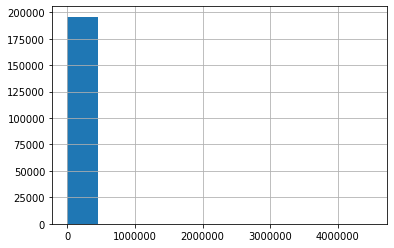

In [9]:
apps['nrating'].hist()

As the original project identified, most games receive very few reviews (including WSS), and this will interfere with the model's ability to predict number of ratings. In addition, we're primarily interested in WSS's performance against games with a similiar or greater level of success (as measured by ratings count). The data was filtered only to include games that had more than 36 reviews. At this threshold, the number of WSS ratings (175) would approximately be located at the median of the ratings distribution. 

Note: we have explored removing games less than 100 reviews, which ended up being 16,583 versus 25,593 games. The model performed much better with a larger data set and this data represents the problem better. Thus, we recommend keeping the threshold as 36 reviews.

In [10]:
apps[apps['title']=='Where Shadows Slumber'][['title','nrating']]

,title,nrating
187751,Where Shadows Slumber,175.0


In [13]:
apps = apps[ (apps['nrating']>36)]
apps['nrating'].describe()

count    2.562600e+04
mean     4.973724e+03
std      4.917892e+04
min      3.650000e+01
25%      7.100000e+01
50%      1.765000e+02
75%      7.285000e+02
max      4.500000e+06
Name: nrating, dtype: float64

## Cleaning Description
Since we included descriptions to the feature, we need to clean the description. We will tokenize and lemmatize the words using nltk. The process is outlined below.
- Tokening: use word_tokenize method from NLTK to split the description text into individual words.
- Removing stop words: use stop words from 'english' to delete both common lower and upper case stop words.
- Joining: join to use Counter function to count the frequency of words in the description.

By using Counter, we want to identify frequency of top 100 keywords in descriptions that are common in:
- All apps (reviews >36)
- Popular apps across all genres
- Popular apps in puzzle
- Popular apps in adventure

Since WSS is listed in both puzzle and adventure genres, we were interested in these two genres. Additionally, we quantified the length of the description because longer descriptions will include more keywords.

In [14]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import en_core_web_sm
nlp = en_core_web_sm.load()
nltk.download('stopwords')
from nltk import word_tokenize
nltk.download('punkt')
stops = nltk.corpus.stopwords.words('english')
stops.extend(['co', 'https', 'http'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrea\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
def clean_words(row):
    review = row['desc'].lower()
    tokens = word_tokenize(review)
    token_words = [w for w in tokens if w.isalpha()]
    meaningful_words = [w for w in token_words if w.lower() not in stops]
    joined_words = ( " ".join(meaningful_words))
    return joined_words 

def lemmatize_doc(doc):
    '''Apply spaCy lemmatization to a document (str)'''
    doc = nlp(doc)
    doc = ' '.join([word.lemma_ for word in doc])
    return doc

apps['processed_stem']= apps.apply(clean_words, axis=1)
apps['processed_stem'] = apps.apply(lambda x: lemmatize_doc(x['processed_stem']), axis=1)
app_number=Counter(' '.join((apps['processed_stem'])).split()).most_common(100)
all_num=pd.DataFrame(app_number, columns=['All_keyword','All_freq'])
all_num.head()

D:\Anaconda\envs\ios\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
D:\Anaconda\envs\ios\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,All_keyword,All_freq
0,game,83770
1,play,38681
2,new,22166
3,free,20342
4,get,19022


In [16]:
apps['desc_len']=apps['desc'].apply(len)
apps['desc_len'].describe()
# Turning off the warning...
pd.options.mode.chained_assignment = None 

D:\Anaconda\envs\ios\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Let's find a way to define "popular apps" by looking at the overall statistics of number of ratings and proportion of star5 ratings.

In [17]:
apps['nrating'].quantile(.95)

11600.0

In [18]:
apps['star5'].describe()

count    25626.000000
mean        66.773433
std         16.668268
min          0.000000
25%         57.000000
50%         69.500000
75%         79.000000
max        100.000000
Name: star5, dtype: float64

As we saw above with the overall statistics, the number of rating is skewed so I will examine the top 5%. The proportion of the 5 star ratings are less skewed, so I will consider games with > 79% ratings as popular game. Thus,  popular apps are defined as number of ratings > 11600 and proportion of the 5 star rating > 79%.

In [19]:
# create a sepearte set with only popular apps and take the top 500 apps, sorted by the number of ratings
popular_apps = apps[(apps['nrating']>11600) & (apps['star5']>79)]
popular_apps = popular_apps.sort_values('nrating',ascending = False).groupby('nrating').head(500)

In [20]:
popular_apps.head()

,title,author,desc,compat,editor,iap,list_rank,nrating,price,score,...,star3,star2,star1,sup_family_sharing,sup_game_center,sup_game_controllers,sup_siri,sup_wallet,processed_stem,desc_len
73405,Fortnite,Epic Games,"Works with: iPhone SE, 6S, 6S Plus, 7, 7 Plus,...",11.0,False,True,True,4500000.0,0.0,4.6,...,3.0,2.0,7.0,1,0,0,0,0,works iphone se plus plus plus x xs xr ipad mi...,1912
157430,Sniper 3D Assassin: Gun Games,Fun Games For Free,Ready to have FUN? Download now the best shoot...,9.0,False,True,True,1700000.0,0.0,4.8,...,3.0,1.0,1.0,1,1,0,0,0,ready fun download good shooting game free lik...,3364
145236,Roblox,Roblox Corporation,Roblox is the ultimate virtual universe that l...,8.0,False,True,True,1600000.0,0.0,4.6,...,3.0,2.0,5.0,1,0,0,0,0,roblox ultimate virtual universe let play crea...,1507
62314,Episode - Choose Your Story,Episode Interactive,"Episode lets you LIVE your stories with love, ...",8.0,False,True,True,1500000.0,0.0,4.7,...,5.0,1.0,2.0,1,0,0,0,0,episode let live story love romance adventure ...,3983
176984,Toon Blast,Peak Games,WELCOME TO THE FUNNIEST CARTOON PUZZLE ADVENTU...,7.0,False,True,True,1400000.0,0.0,4.7,...,5.0,1.0,1.0,1,0,0,0,0,welcome funniest cartoon puzzle adventure crea...,961


In [21]:
# take only the top 200 to save computational time
popular_all=popular_apps.head(200)
popular_all['processed_stem'] = popular_all.apply(clean_words, axis=1)
joined_popular_all=Counter(' '.join(popular_all['processed_stem']).split()).most_common(100)
pop_twohun=pd.DataFrame(joined_popular_all, columns=['Pop_all_keyword', 'Pop_all_freq'])

In [22]:
pop_twohun.head()

,Pop_all_keyword,Pop_all_freq
0,game,529
1,subscription,460
2,play,368
3,free,317
4,new,288


In [23]:
# Observe top key words in puzzle genre
puzzle=popular_apps[popular_apps['gen_puzzle']==1]
puzzle['processed_stem'] = puzzle.apply(clean_words, axis=1)
puzzle['processed_stem'] = puzzle.apply(lambda x: lemmatize_doc(x['processed_stem']), axis=1)
joined_puzzle=Counter(' '.join(puzzle['processed_stem']).split()).most_common(100)
keyword_puzz=pd.DataFrame(joined_puzzle, columns=['Pop_puzz_keyword', 'Pop_puzz_freq'])
keyword_puzz.head()

,Pop_puzz_keyword,Pop_puzz_freq
0,game,478
1,puzzle,311
2,play,270
3,subscription,228
4,level,202


In [24]:
adventure=popular_apps[popular_apps['gen_adventure']==1]
adventure['processed_stem'] = adventure.apply(clean_words, axis=1)
adventure['processed_stem'] = adventure.apply(lambda x: lemmatize_doc(x['processed_stem']), axis=1)
joined_adventure=Counter(' '.join(adventure['processed_stem']).split()).most_common(100)
keyword_adv=pd.DataFrame(joined_adventure, columns=['Pop_adv_keyword', 'Pop_adv_freq'])
keyword_adv.head()

,Pop_adv_keyword,Pop_adv_freq
0,game,197
1,new,119
2,play,110
3,world,83
4,subscription,79


## Description Exploration
To make a keyword comparison across different groups, we will put all the data in a single dataframe and save the dataframe as a database to give busineess recommendation to Game Revenant. You can see there are some common words that appear across the different genre like "game" and "subscription". 

Note: with lemmatization, some pronouns are count as -PRON- and this can be ignored for our purpose.

In [25]:
tot_pd=pd.concat([all_num, pop_twohun, keyword_puzz, keyword_adv ], axis=1, join='inner')
tot_pd.to_sql('lemmon_key_desc', e, if_exists='replace', index=False)
tot_pd

,All_keyword,All_freq,Pop_all_keyword,Pop_all_freq,Pop_puzz_keyword,Pop_puzz_freq,Pop_adv_keyword,Pop_adv_freq
0,game,83770,game,529,game,478,game,197
1,play,38681,subscription,460,puzzle,311,new,119
2,new,22166,play,368,play,270,play,110
3,free,20342,free,317,subscription,228,world,83
4,get,19022,new,288,level,202,subscription,79
...,...,...,...,...,...,...,...,...
95,color,4623,within,60,connect,34,ultimate,20
96,ipad,4621,easy,60,special,34,action,20
97,learn,4603,battles,60,itunes,34,control,20
98,let,4593,skills,59,unique,33,allow,20


To visualize, we can plot them in bar graphs to compare across different groups that we have picked out.

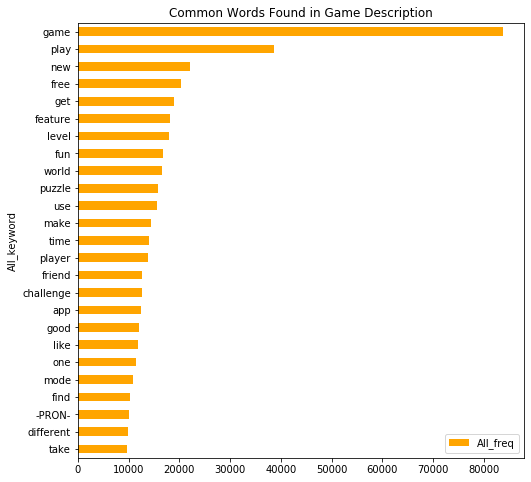

In [26]:

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
tot_pd.head(25).sort_values(by='All_freq').plot.barh(x='All_keyword', y='All_freq', ax=ax, color="orange")

ax.set_title('Common Words Found in Game Description')
plt.show()

Text(0.5, 1.0, 'Common Words Found in Adventure Game Description')

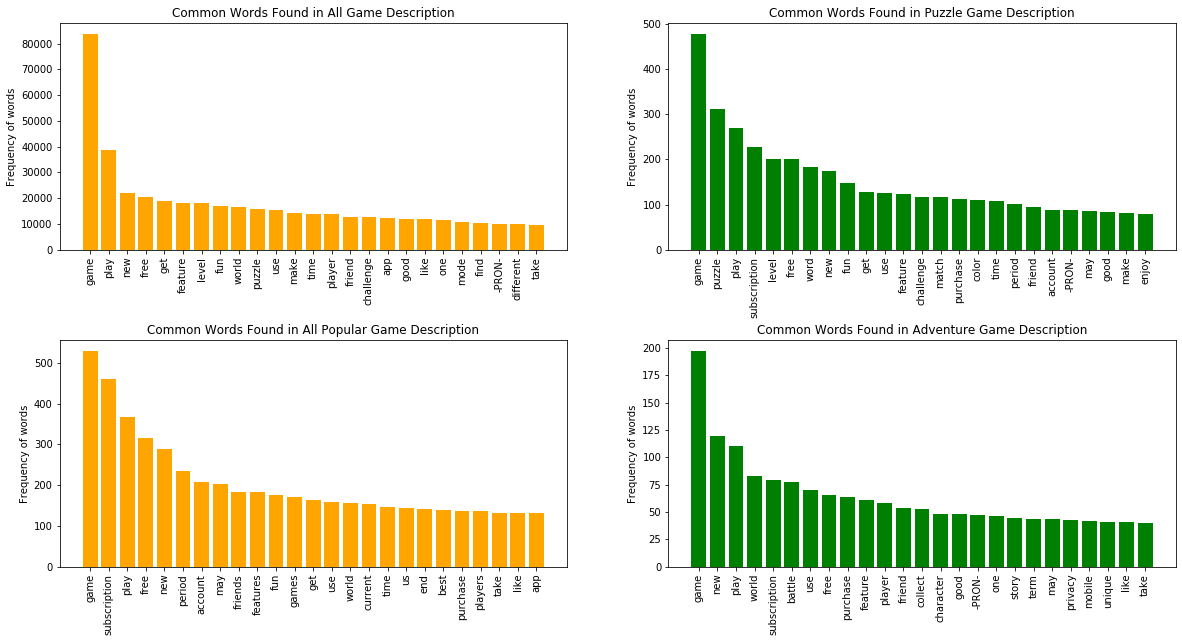

<Figure size 1440x720 with 0 Axes>

In [27]:
fig, axs = plt.subplots(2,2, figsize=(20,10))
plt.subplots_adjust(wspace = 0.2,hspace = 0.4)
axs = axs.flatten()

xpos = np.arange(25)

fig = plt.figure(figsize=(20,10))
fig.tight_layout()
num_list=[0,2]
for i in num_list:
    axs[i].bar(xpos, list(tot_pd.iloc[:,i+1].head(25)), color='orange')
    axs[i].set_ylabel('Frequency of words')
    axs[i].set_xticks(xpos)
    axs[i].set_xticklabels(list(tot_pd.iloc[:,i]), rotation=90)
num_list=[4,6]
for i in num_list:
    axs[i-3].bar(xpos, list(tot_pd.iloc[:,i+1].head(25)), color='green')
    axs[i-3].set_ylabel('Frequency of words')
    axs[i-3].set_xticks(xpos)
    axs[i-3].set_xticklabels(list(tot_pd.iloc[:,i]), rotation=90)
axs[0].set_title('Common Words Found in All Game Description')
axs[1].set_title('Common Words Found in Puzzle Game Description')
axs[2].set_title('Common Words Found in All Popular Game Description')
axs[3].set_title('Common Words Found in Adventure Game Description')
#sns.barplot(x='All_keyword', y='All_freq', data=tot_pd.head(25), kind='bar', ax=ax)  # <- notice ax= argument

Since top games seem to include subscription as a part of the description, we will consider this as a feature. More on this will be illustrated in a later section.


## Quantifying Descriptions: Feature Engineering

With the list of descriptions and frequencies, we now can quantify description and engineer features to create the regression model. Since some words are mentioned more frequently than other words, the importance of the word needs to be weighted (ie, the word "game" may be more important to have than the word "take"). To do this, we will use CountVectorizer and create SparseMatrix. To decide which set of words and frequencies to use, let's see if there are enough games with both puzzle and adventure genres in popular games.


In [28]:
pop_puzadv=popular_apps[(popular_apps['gen_puzzle']==1) & (popular_apps['gen_adventure']==1)]
pop_puzadv

,title,author,desc,compat,editor,iap,list_rank,nrating,price,score,...,star3,star2,star1,sup_family_sharing,sup_game_center,sup_game_controllers,sup_siri,sup_wallet,processed_stem,desc_len
20665,Best Fiends - Puzzle Adventure,Seriously,"Join over 90,000,000 people who are already pl...",9.0,True,True,True,123950.0,0.00,4.8,...,2.0,0.0,1.0,1,1,0,0,0,join people already playing free puzzle advent...,3394
47797,Criminal Case,Pretty Simple,Join the Police of Grimsborough to solve a ser...,9.0,False,True,True,22000.0,0.00,4.6,...,3.0,2.0,4.0,1,0,0,0,0,join police grimsborough solve series murder c...,1503
65002,FROST,kunabi brother GmbH,Draw paths to guide the flocking spirits to th...,9.0,True,False,True,13600.0,4.99,4.9,...,2.0,0.0,1.0,1,0,0,0,0,draw path guide flock spirit home planet watch...,769


As shown here, there are only three games that are both listed as puzzle and adventure genres. Since the words listed in puzzle and adventure seem to be too specific and not as relevant to WSS (eg, battle, word), we picked popular game of all genres as a table to use for the feature engineering.

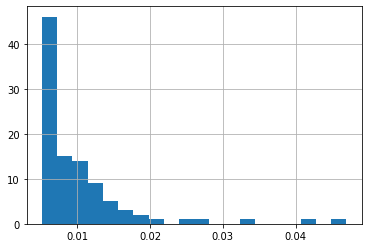

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

# Use words in top score to weigh the importance of each word by summing the total frequency and dividing by each word 
pop_twohun['Top score']=pop_twohun['Pop_all_freq'].div(pop_twohun['Pop_all_freq'].sum())
corpus=pop_twohun['Pop_all_keyword'].values.tolist()
pop_twohun['Top score'].hist(bins=20)

In [30]:
pop_twohun['Top score'].describe()

count    100.000000
mean       0.010000
std        0.006915
min        0.005151
25%        0.005951
50%        0.007594
75%        0.011435
max        0.046985
Name: Top score, dtype: float64

In [31]:
pop_twohun=pop_twohun.sort_values('Pop_all_keyword', ascending=True).reset_index(drop=True)
pop_twohun

,Pop_all_keyword,Pop_all_freq,Top score
0,account,209,0.018563
1,also,62,0.005507
2,app,131,0.011635
3,automatically,68,0.006040
4,battle,109,0.009681
...,...,...,...
95,way,78,0.006928
96,weekly,69,0.006128
97,win,90,0.007994
98,within,60,0.005329


Note that we need to arrange the keyword in alphabetical order to match vectorizer feature names seen below.

In [32]:
''' Using CountVectorizer, it will go through the description, count the number of frequency for each word 
in each desciption, multiply the frequency by the weight, and sum up the total score '''
X = vectorizer.fit_transform(corpus)
words=vectorizer.get_feature_names()
words[1:6]

['also', 'app', 'automatically', 'battle', 'battles']

As you can see here, the sps_mat shows you the occurence of the each word for each game.

In [33]:
sps_mat=pd.DataFrame(vectorizer.transform(apps['processed_stem']).toarray()).T
sps_mat

,0,1,2,3,4,5,6,7,8,9,...,25616,25617,25618,25619,25620,25621,25622,25623,25624,25625
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,2,2,0,2,2,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,1,4,4,4,1,1,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


You can then multiply the sparse matrix with the words that are sorted alphabetically to get a sum of the score.

In [34]:
ranking_all=sps_mat.mul(pop_twohun['Top score'], axis=0)
ranking_all=ranking_all.sum(axis = 0, skipna = True)
ranking_all

0        0.156053
1        0.374989
2        0.135092
3        0.142020
4        0.228795
           ...   
25621    0.502887
25622    0.279687
25623    0.891998
25624    0.530242
25625    0.000000
Length: 25626, dtype: float64

This will be added to the master database "apps".

In [62]:
apps=apps.reset_index(drop=True)
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25626 entries, 0 to 25625
Data columns (total 60 columns):
title                       25626 non-null object
author                      25626 non-null object
desc                        25626 non-null object
compat                      25626 non-null float64
editor                      25626 non-null bool
iap                         25626 non-null bool
list_rank                   25626 non-null bool
nrating                     25626 non-null float64
price                       25626 non-null float64
score                       25626 non-null float64
size                        25626 non-null float64
age_12                      25626 non-null uint8
age_17                      25626 non-null uint8
age_4                       25626 non-null uint8
age_9                       25626 non-null uint8
gen_action                  25626 non-null uint8
gen_adventure               25626 non-null uint8
gen_board                   25626 non-null uint8

In [63]:
apps.insert(loc=3, column='desc_score', value=ranking_all)
apps.head()

,title,author,desc,desc_score,compat,editor,iap,list_rank,nrating,price,...,star2,star1,sup_family_sharing,sup_game_center,sup_game_controllers,sup_siri,sup_wallet,processed_stem,desc_len,subscription
0,! Chess !,xiaojian chen,Chess King is the best Chess game. Touch the s...,0.156053,7.0,False,False,False,199.0,0.00,...,2.0,3.0,1,1,0,0,0,chess king good chess game touch screen move d...,520,0
1,!Rebolt! Lite,Flashbang Studios,This is the Lite version of Rebolt -- if you e...,0.374989,2.0,False,False,False,1500.0,0.00,...,18.0,26.0,1,0,0,0,0,lite version rebolt enjoy buy full version ext...,1351,0
2,""" Snow fall princess High-land "" Dress-up : Th...",Laongdow Panasantikul,If You love Snow Princess. She'll back!! Every...,0.135092,8.0,False,True,False,97.0,0.00,...,4.0,3.0,1,0,0,0,0,love snow princess back everyone love dress ge...,426,0
3,"""HOOK""",Maciej Targoni,"""Hook"" is a relaxing, minimal, puzzle game. It...",0.142020,8.0,False,False,True,349.0,0.99,...,1.0,1.0,1,0,0,0,0,hook relax minimal puzzle game experience chal...,358,0
4,"""OXXO""",Michal Pawlowski,"Hey, Hamster here! I create puzzle games for y...",0.228795,8.0,False,False,True,107.0,1.99,...,1.0,0.0,1,0,0,0,0,hey hamster create puzzle game scalak zenge pu...,616,0


We can do an overall check to see if the desc_score captures what we intend to by looking at some examples.

In [64]:
apps['desc_score'].describe()

count    25626.000000
mean         0.444243
std          0.373504
min          0.000000
25%          0.178169
50%          0.345501
75%          0.592681
max          2.943157
Name: desc_score, dtype: float64

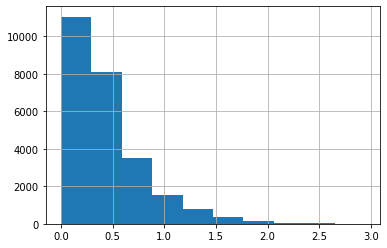

In [65]:
apps['desc_score'].hist()

In [67]:
# Find the game with the shorted desc length to check the score
apps[(apps['desc_len'])==(min(apps['desc_len']))]

,title,author,desc,desc_score,compat,editor,iap,list_rank,nrating,price,...,star2,star1,sup_family_sharing,sup_game_center,sup_game_controllers,sup_siri,sup_wallet,processed_stem,desc_len,subscription
2088,Basketball MMC,MobileMediaCom,Basketball game,0.046985,3.0,False,False,False,104.0,0.0,...,14.0,22.0,1,0,0,0,0,basketball game,15,0


In [68]:
''' Since the description of the game is "basketbal game" and we know game is one of the top words used in description, 
we can easily check if the score of game and desc_score match''' 
pop_twohun[pop_twohun['Pop_all_keyword']==('game')]

,Pop_all_keyword,Pop_all_freq,Top score
38,game,529,0.046985


In [69]:
# Additionally, the last game in the apps is in Chinese, which means that the desc_score has to be zero
apps[['desc', 'desc_score']].iloc[-1]

desc          《Puzzle8填字》是由益智游戏网站Puzzle8.com 推出的中文填字游戏app，Pu...
desc_score                                                    0
Name: 25625, dtype: object

Since they both output expected value, we can create one last feature. We can pick out the word 'subscription' from processed words to create a categorical value. Then, we are finally done with creating the database!

In [70]:
apps['subscription']=0
apps.loc[apps['processed_stem'].str.contains('subscription', case=False), 'subscription'] = 1
apps['subscription'].describe()

count    25626.000000
mean         0.038828
std          0.193188
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: subscription, dtype: float64

In [71]:
apps.to_sql('clean_db', e, if_exists='replace', index=False)

# Creating Regression Models
## Generating Test and Training Sets

Number of rating is our target metric. Since the number of rating is not normally distributed, we will use StratifiedShuffleSplit to create test and training sets. Then we will transform skewed data through the pipeline to help with the model performance.

In [2]:
apps=pd.read_sql_query('''SELECT * FROM clean_db''', sa.create_engine(r'sqlite:///D:\Program_practices\IOS\app-store.sqlite'))
apps.head()

,title,author,desc,desc_score,compat,editor,iap,list_rank,nrating,price,...,star2,star1,sup_family_sharing,sup_game_center,sup_game_controllers,sup_siri,sup_wallet,processed_stem,desc_len,subscription
0,! Chess !,xiaojian chen,Chess King is the best Chess game. Touch the s...,0.156053,7.0,0,0,0,199.0,0.00,...,2.0,3.0,1,1,0,0,0,chess king good chess game touch screen move d...,520,0
1,!Rebolt! Lite,Flashbang Studios,This is the Lite version of Rebolt -- if you e...,0.374989,2.0,0,0,0,1500.0,0.00,...,18.0,26.0,1,0,0,0,0,lite version rebolt enjoy buy full version ext...,1351,0
2,""" Snow fall princess High-land "" Dress-up : Th...",Laongdow Panasantikul,If You love Snow Princess. She'll back!! Every...,0.135092,8.0,0,1,0,97.0,0.00,...,4.0,3.0,1,0,0,0,0,love snow princess back everyone love dress ge...,426,0
3,"""HOOK""",Maciej Targoni,"""Hook"" is a relaxing, minimal, puzzle game. It...",0.142020,8.0,0,0,1,349.0,0.99,...,1.0,1.0,1,0,0,0,0,hook relax minimal puzzle game experience chal...,358,0
4,"""OXXO""",Michal Pawlowski,"Hey, Hamster here! I create puzzle games for y...",0.228795,8.0,0,0,1,107.0,1.99,...,1.0,0.0,1,0,0,0,0,hey hamster create puzzle game scalak zenge pu...,616,0


Try in the future: addressing multi-collinearity
https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class
irrelevant = ['processed_stem','sup_family_sharing','sup_game_center','sup_game_controllers', 'sup_siri','sup_wallet', 'author', 'desc']
app_id= ['title']
apps=apps.drop(columns=irrelevant)
apps=apps.drop(columns=app_id)
apps.info()
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [3]:
apps['nrating'].quantile(.95)

11600.0

In [4]:
# removing top 5% of the game
len(apps[apps['nrating']>11600])
apps=apps[apps['nrating']<=11600]

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

# Divide them into given bins to ensure that the number of ratings distribution represents the train and test sets
bins = [36, 100, 1000, 10000, 100000, np.inf]
labels=[1, 2, 3, 4, 5]
# create a new column containing the ratings bin the game is associated with
apps['nrating_cut'] = pd.cut(apps['nrating'], bins=bins, labels=labels)

# split data into training (80%) and testing (20%) sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_ind, test_ind in split.split(apps, apps['nrating_cut']):
    train_set, test_set = apps.iloc[train_ind], apps.iloc[test_ind]

test_label = test_set['nrating'].copy()
test_identity = test_set[['title','author', 'desc']].copy()
test_set = test_set.drop(columns=['nrating_cut','nrating','title','author','desc','processed_stem', 'list_rank'])

train_label = train_set['nrating'].copy()
train_identity = train_set[['title','author', 'desc']].copy()
train_set_binned = train_set['nrating_cut'].copy() # label identifying the ratings bin the game occupies
train_set = train_set.drop(columns=['nrating_cut','nrating','title','author','desc','processed_stem','list_rank']) 
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 1727 to 9487
Data columns (total 55 columns):
desc_score                  4870 non-null float64
compat                      4870 non-null float64
editor                      4870 non-null int64
iap                         4870 non-null int64
price                       4870 non-null float64
score                       4870 non-null float64
size                        4870 non-null float64
age_12                      4870 non-null int64
age_17                      4870 non-null int64
age_4                       4870 non-null int64
age_9                       4870 non-null int64
gen_action                  4870 non-null int64
gen_adventure               4870 non-null int64
gen_board                   4870 non-null int64
gen_card                    4870 non-null int64
gen_casino                  4870 non-null int64
gen_casual                  4870 non-null int64
gen_family                  4870 non-null int64
gen_music       

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000282828726C8>,
      dtype=object)

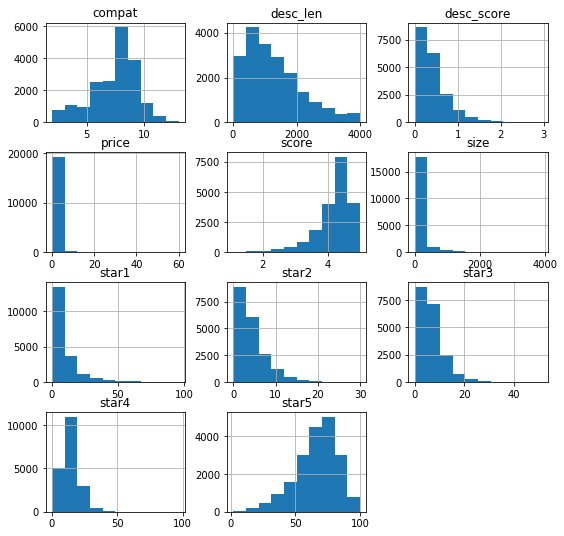

In [6]:
# get index of numeric features (as opposed to categorical features) that will need to be preprocesse
train_set['desc_len']=train_set['desc_len'].astype(float)
numeric_feat = train_set.dtypes[train_set.dtypes == 'float64'].index

train_set[numeric_feat].hist(bins=10, figsize=(9,9))

## Data Transformation
To streamline skew correction, a custom transformer is created in conjunction with a data pipeline. The pipeline also implements StandardScalar, which normalizes the features to have a mean of 0 and standard deviation of 1.

In [7]:
# Apply transformation 

from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import skew
from scipy.stats import boxcox

class SkewCorrector(BaseEstimator, TransformerMixin):
    
    def __init__(self, skew_bound=0.2): # skew_bound is amount of skew that is acceptable
        self.skew_bound = skew_bound
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_val = X.to_numpy()
        # different distributions require different transforms; indicies are defined below for specific data types
        ind_skewed = np.absolute(skew(X_val)) > self.skew_bound
        ind_right_skew = skew(X_val) > 0
        ind_left_skew = skew(X_val) < 0
        ind_no_zeros = [0 not in X_val[:,col] for col in np.arange(X_val.shape[1])]
        ind_has_zeros = [0 in X_val[:,col] for col in np.arange(X_val.shape[1])]
        # if all elements in a feature column are positive, the sum of all those should be equal to the number of rows in that feature matrix
        ind_positive = [np.sign(X_val[:,col]).sum() == X_val.shape[0] for col in np.arange(X_val.shape[1])]

        # transform right and left skewed data that does not include zero values with boxcox
        X_trans, _ = np.apply_along_axis(boxcox, 0, X_val[:,ind_skewed & ind_no_zeros & ind_positive]) # returns list of arrays
        X_val[:,ind_skewed & ind_no_zeros & ind_positive] = np.vstack(X_trans).T
        
        # transform right skewed data that contains zero values with log plus one
        X_trans = np.log1p(X_val[:,ind_skewed & ind_right_skew & ind_has_zeros])
        X_val[:,ind_skewed * ind_right_skew * ind_has_zeros] = X_trans
        
        # transform left skewed data that contains zero values by increasing power incrementally
        for pwr in range(2, 5): #arbitarily set the power limit to 5; maybe make this a user-defined parameter?
            X_trans = X_val[:,ind_skewed * ind_left_skew * ind_has_zeros]**pwr
            if skew(X_trans) < self.skew_bound:
                break
        
        X_val[:,ind_skewed * ind_left_skew * ind_has_zeros] = X_trans
        
        # Update the input data frame with transformed values
        X_out = pd.DataFrame(X_val, index=X.index, columns=X.columns)
        return X_out

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('trans_skew', SkewCorrector(skew_bound=0.2)),
    ('std_scaler', StandardScaler())
])
numeric_feat = train_set.dtypes[train_set.dtypes == 'float64'].index
cat_feat = train_set.dtypes[train_set.dtypes != 'float64'].index

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numeric_feat)
])

train_set_processed = train_set.copy()

Plotting the numeric features after preprocessing indicates that most of the distributions have become approximately normal including the new features. Again, as shown in the previous work, the price is heavily skewed (ie, almost all games have a price of $0.00).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028283BC1408>,
      dtype=object)

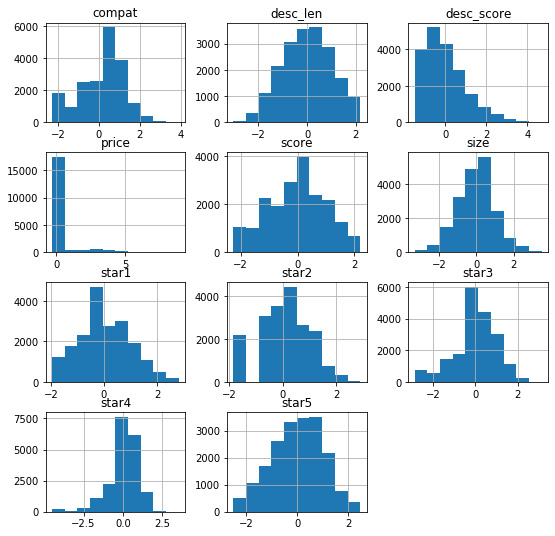

In [9]:
train_set_processed[numeric_feat] = full_pipeline.fit_transform(train_set[numeric_feat])
train_set_processed[numeric_feat].hist(bins=10, figsize=(9,9))

## Choosing Models: Cross-validation

The next step is to choose an appropriate model for the data that we have. We will be fitting multiple models to subsets of the training data, mostly using the default hyperparameters to get a general sense of what are appropriate models. Due to the large outliers, mean absolute error was used in calculating the cross validation scores.

The following regressors were evaluated: linear regression, elastic net, stochastic gradient descent, linear support vector, k-nearest neighbor, random forest, and gradient tree boosting.

Prior to cross validation, stratified sampling was used to ensure that the training and validation folds had similiar ratings distributions (in the same way stratified sampling was used to separate the initial data set into training and testing sets). The k-fold has been decreased to 5 to speed up the computation.

In [10]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from functools import partial
    
def init_cv_gen():
    '''Helper function that returns a generator for cross-validation'''
    skf = StratifiedKFold(5, shuffle=True, random_state=42).split(train_set_processed, train_set_binned)
    return skf

def cv_score(estimator):
    '''Generates cross validation scores; used to keep code clean when testing different models (estimator)'''
    cv = init_cv_gen()
    cv_score = cross_val_score(estimator=estimator, X=train_set_processed, y=train_label, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
    return cv_score

def show_cv_result(scores):
    '''Print mean and standard deviation of an array of cross validation scores'''
    print(f'Cross validation mean score is : {np.mean(scores)} ± {np.std(scores)}')

In [16]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(train_set_processed, train_label)

scores = cv_score(reg)
show_cv_result(-scores)

Cross validation mean score is : 851.800892572854 ± 10.550538868322265


In [17]:
from sklearn.linear_model import ElasticNet

ENreg = ElasticNet()
ENreg.fit(train_set_processed, train_label)

ENscores = cv_score(ENreg)
show_cv_result(-ENscores)

Cross validation mean score is : 857.5854900773269 ± 13.080752421935442


In [11]:
from sklearn.linear_model import SGDRegressor

SGDreg = SGDRegressor(loss='huber',max_iter=5000, tol=1e-3)
SGDreg.fit(train_set_processed, train_label)

SGDscores = cv_score(SGDreg)
show_cv_result(-SGDscores)

Cross validation mean score is : 664.1992856066033 ± 16.597560875272343


In [12]:
from sklearn.svm import LinearSVR

SVRreg = LinearSVR()
SVRreg.fit(train_set_processed, train_label)

SVRscores = cv_score(SVRreg)
show_cv_result(-SVRscores)

Cross validation mean score is : 654.4700059004115 ± 16.329078220318628


In [20]:
from sklearn.neighbors import KNeighborsRegressor

KNreg = KNeighborsRegressor()
KNreg.fit(train_set_processed, train_label)

KNscores = cv_score(KNreg)
show_cv_result(-KNscores)

Cross validation mean score is : 879.7718044018244 ± 6.630855080795827


Since random forest and gradient tree boosting both rely on decision trees (non-parametric), there is no need to standardize the input data or correct for skew.

In [21]:
from sklearn.ensemble import RandomForestRegressor

RFRreg = RandomForestRegressor(n_estimators=100, random_state=42)
RFRreg.fit(train_set, train_label)

RFRscores = cv_score(RFRreg)
show_cv_result(-RFRscores)

Cross validation mean score is : 801.1630108588163 ± 4.83183020923547


In [13]:
from sklearn.ensemble import GradientBoostingRegressor

GBRreg = GradientBoostingRegressor(loss='huber', random_state=42)
GBRreg.fit(train_set, train_label)

GBRscores = cv_score(GBRreg)
show_cv_result(-GBRscores)

Cross validation mean score is : 653.0811111425517 ± 12.582171705959524


In [24]:
import xgboost as xgb
XGBreg=xgb.XGBRegressor(random_state=42)
XGBreg.fit(train_set, train_label)
XGBscores = cv_score(XGBreg)
show_cv_result(-XGBscores)

D:\Anaconda\envs\ios\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:06:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Cross validation mean score is : 765.6451583549152 ± 7.600491405017745


With the lowest MAE, the best models to optimize further are stochastic gradient descent regression (SGD), linear support vector regression (SVR), and gradient boosted regression (GBR). A grid search was performed to find the optimal hyperparameters.

In [14]:
from sklearn.model_selection import GridSearchCV
# SGD
param_grid = [
    {
        'penalty': ['none', 'elasticnet'],
        'loss': ['huber', 'epsilon_insensitive'],
        'alpha': [1, 0.1, 1e-2, 1e-3, 1e-4],
        'learning_rate': ['invscaling', 'adaptive']
    }
]
SGDreg = SGDRegressor(max_iter=2000, tol=1e-3, early_stopping=True)

sgd_grid = GridSearchCV(SGDreg, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
sgd_grid.fit(train_set_processed, train_label)
-sgd_grid.best_score_

656.2517079574625

In [15]:
# GBR
param_grid = [
    {
        'max_depth': [3, 9],
        'learning_rate': [0.01, 0.1, 1],
        'loss' : ['huber', 'lad']
    }
]

GBRreg = GradientBoostingRegressor(random_state=42)

GBR_grid = GridSearchCV(GBRreg, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
GBR_grid.fit(train_set, train_label)
-GBR_grid.best_score_


609.0911156380364

In [16]:
# SVR
param_grid = [
    {
        'epsilon': [0, .1, 1, 10, 100],
        'C': [1, 10, 100, 1000]
    }
]

SVRreg = LinearSVR(max_iter=10000)

SVR_grid = GridSearchCV(SVRreg, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
SVR_grid.fit(train_set_processed, train_label)
-SVR_grid.best_score_

652.2313279286079

We will take GBR to do one more round of grid search.

In [17]:
GBR_grid.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='lad', max_depth=9,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
param_grid = [
    {
          'max_depth': [9],
        'n_estimators': [50],
        'loss' : ['lad'],
       'learning_rate' : [0.1],
        'warm_start' :[True, False],
        'min_samples_split' : [10, 20, 100]
    }
]

GBRreg = GradientBoostingRegressor(random_state=42)

GBR_grid = GridSearchCV(GBRreg, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
GBR_grid.fit(train_set, train_label)
-GBR_grid.best_score_

603.4609962935335

In [19]:
GBR_grid.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='lad', max_depth=9,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=100,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=True)

We choose GBR as the model based on the score we received. Running the grid search again did not improve the score as much.

In [20]:
from sklearn.metrics import mean_absolute_error, median_absolute_error

train_predict = GBR_grid.best_estimator_.predict(train_set)
test_predict = GBR_grid.best_estimator_.predict(test_set)

# mean absolute error calculation
mae_train = mean_absolute_error(train_label, train_predict)
mae_test = mean_absolute_error(test_label, test_predict)
# median absolute error calculation
medae_train = median_absolute_error(train_label, train_predict)
medae_test = median_absolute_error(test_label, test_predict)
# print results
print(f'Training set mean absolute error and median absolute error is {mae_train} and {medae_train}, respectively')
print(f'Test set mean absolute error and median absolute error is {mae_test} and {medae_test}, respectively')

Training set mean absolute error and median absolute error is 580.4058354490335 and 100.20311453640863, respectively
Test set mean absolute error and median absolute error is 607.1080163787259 and 118.97868662760446, respectively


Testing error is slightly higher compared to the training error as expected.

In [93]:
GBR_grid.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='lad', max_depth=9,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=50,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=True)

Now we will look at what features are important in predicting the number of rating.

# Interpreting the Model
## Feature Importance

As mentioned in the previous project, we used permutation importances, which are based on the test set and are not biased towards high cardinality features (https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html).

Here, the features are plotted in order of importance.

Text(0.5, 1.0, 'Permutation Importances (based on test set)')

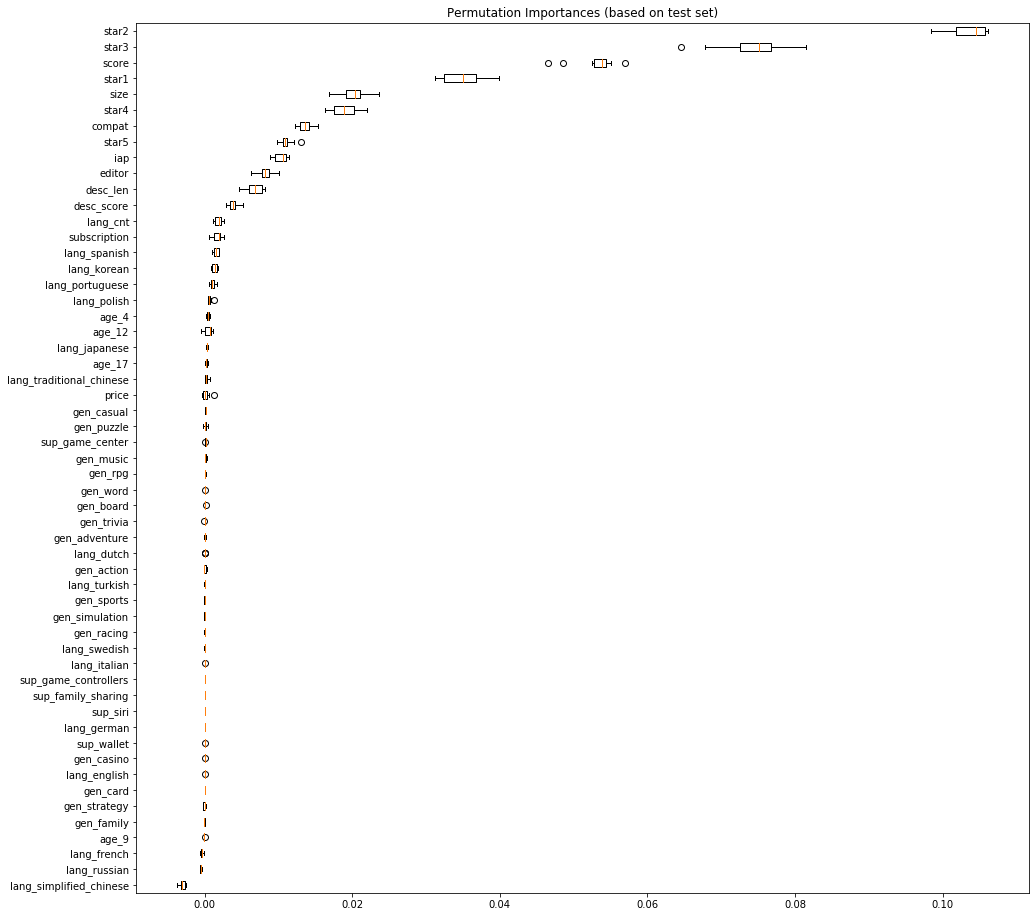

In [23]:
from sklearn.inspection import permutation_importance

result = permutation_importance(GBR_grid.best_estimator_, test_set, test_label, n_repeats=10,
                                random_state=42)

# sort to plot in order of importance
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(16,16))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=test_set.columns[sorted_idx])

ax.set_title("Permutation Importances (based on test set)")

Based on the results above, we can suggest that:

- Previous project has discussed that he Chinese market is not particularly influential, but we recently learned that each country has a separate app store. The fact that simplified Chinese feature is ranked the lowest informs that users in the US do not consider this feature important since most US users will likely download games in English. Thus, we have to keep in mind that this represents the US iOS App store information. 

- Still, this model agrees with the previous work that that adding additional languages, specific genre, age ratings, and app supplementary features (eg, game controller) are not important in predicting the number of rating.

- Surprisingly, the three new features that we added, description score, description length, and subscription are not as important as we expected; however, modifying the description still can influence the number of ratings or even downloads by increasing a search appearance within the App store. It may be worth it to monitor the number of ratings after changing the description of WSS to see if there are benefits that are not measured by the model.

- Both star 2 and 3 ratings are considered to be the most important features for the model. When thinking from a user's point of view, users who give 2 or 3 stars tend to write detailed explanation for the rating, whereas users who give 5 and 1 ratings tend to be brief. You might consider users who give 2 or 3 starts tend to be more serious with mobile gaming and giving feedback, and these users are more likely to leave ratings than other casual players. With the increase in game populatrity, it is likely that more serious users download and leave reviews.

- Compared to the previous project, price was ranked much lower in importance. We are particularly interested in price because WSS requires you to buy the game upfront and does not offer any additional in-app purchases. Even though the price was ranked much lower, it is hard to imagine that this does not influence the number of ratings, considering that the many top games are free. This can be due to a small number of games that require to buy the game upfront, and thus we may not have enough training set to properly train the model and make the conclusion. Yet, the higher ranking of in-app purchase and subscription than price may suggest that this is a general trend that mobile games are heading toward. Future mobile games should consider in-app purchases and subscription as a business model instead of charging games upfront. Game Reverant is currently working on changing the business model based on the previous recommendation.

The most 15 important features are:
- Star 2
- Star 3
- Score
- Star 1
- Size
- Star 4
- Compatibility
- Star 5
- Availability of in-app purchase
- Editor's choice 
- Length of description
- Score by description
- Language count
- Subscription
- Spanish
- Price 

Now, we will look at 15 random games to see how well it predicts.

In [29]:
# We can also look at 15 random games
ex = apps.sample(n = 15)

ex_summary = ex[['title','nrating']].copy()
ex_feat = ex.drop(columns=['nrating','title','author','desc','processed_stem', 'nrating_cut','list_rank','processed_stem'])
ex_summary['predicted_nrating'] = GBR_grid.best_estimator_.predict(ex_feat)

ex_summary

,title,nrating,predicted_nrating
6531,Dice Match,87.5,78.885312
8133,Excavator,246.0,146.980652
3811,Call of Sniper War 2019,97.5,94.603999
17724,Push Maze Puzzle,85.0,52.234497
24637,Word Bakery: The Search & find,109.0,130.652668
4066,Captain Rocket,65.0,129.475113
18529,Rising Tower - Block Stack Up,46.0,87.992600
17569,Princess Siwa Nail Salon,470.5,244.021209
17248,Poker™,176.0,156.011579
15972,Octagon - A Minimal Arcade Game with Maximum C...,532.0,246.632808


To better illustrate the influence of each feature, the WSS and four similiar game titles are examined. These games are similar to WSS in genre, style, and tone. All of these titles are "premium" games (ie, not free to play).

In [32]:
examples = ['Where Shadows Slumber', 'Monument Valley',
            'LIMBO', 'Journey', 'Rusty Lake Paradise']

ex = apps[apps['title'].isin(examples)].copy()

ex_summary = ex[['title','nrating']].copy()
ex_feat = ex.drop(columns=['nrating','title','author','desc','processed_stem', 'nrating_cut', 'list_rank','processed_stem'])
ex_summary['predicted_nrating'] = GBR_grid.best_estimator_.predict(ex_feat)

ex_summary

,title,nrating,predicted_nrating
12391,Journey,61.0,347.190325
13016,LIMBO,2100.0,825.755243
14987,Monument Valley,3300.0,936.431726
18965,Rusty Lake Paradise,1100.0,433.837130
24332,Where Shadows Slumber,175.0,305.075075


The model behaves decently well in predicting the number of ratings as a whole.

## Important Numerical Features

We will now select the top fifteen features + price to investigate how changes to each parameter may influence the number of ratings. The numerical features that we will use are:
- Star 2
- Star 3
- Score
- Star 1
- Size
- Star 4
- Compatibility
- Star 5
- Length of description
- Score by description
- Language count
- Price 

Here, only feature values that lie between the 15th and 85th percentile in frequency of occurence will be tested. Feature values that do not occur often are not tested. Note that analysis of price will require a larger range of values to be considered (1-99th percentile), since free games greatly outnumber premium ones.

In [26]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24347 entries, 0 to 25625
Data columns (total 62 columns):
title                       24347 non-null object
author                      24347 non-null object
desc                        24347 non-null object
desc_score                  24347 non-null float64
compat                      24347 non-null float64
editor                      24347 non-null int64
iap                         24347 non-null int64
list_rank                   24347 non-null int64
nrating                     24347 non-null float64
price                       24347 non-null float64
score                       24347 non-null float64
size                        24347 non-null float64
age_12                      24347 non-null int64
age_17                      24347 non-null int64
age_4                       24347 non-null int64
age_9                       24347 non-null int64
gen_action                  24347 non-null int64
gen_adventure               24347 non-null 

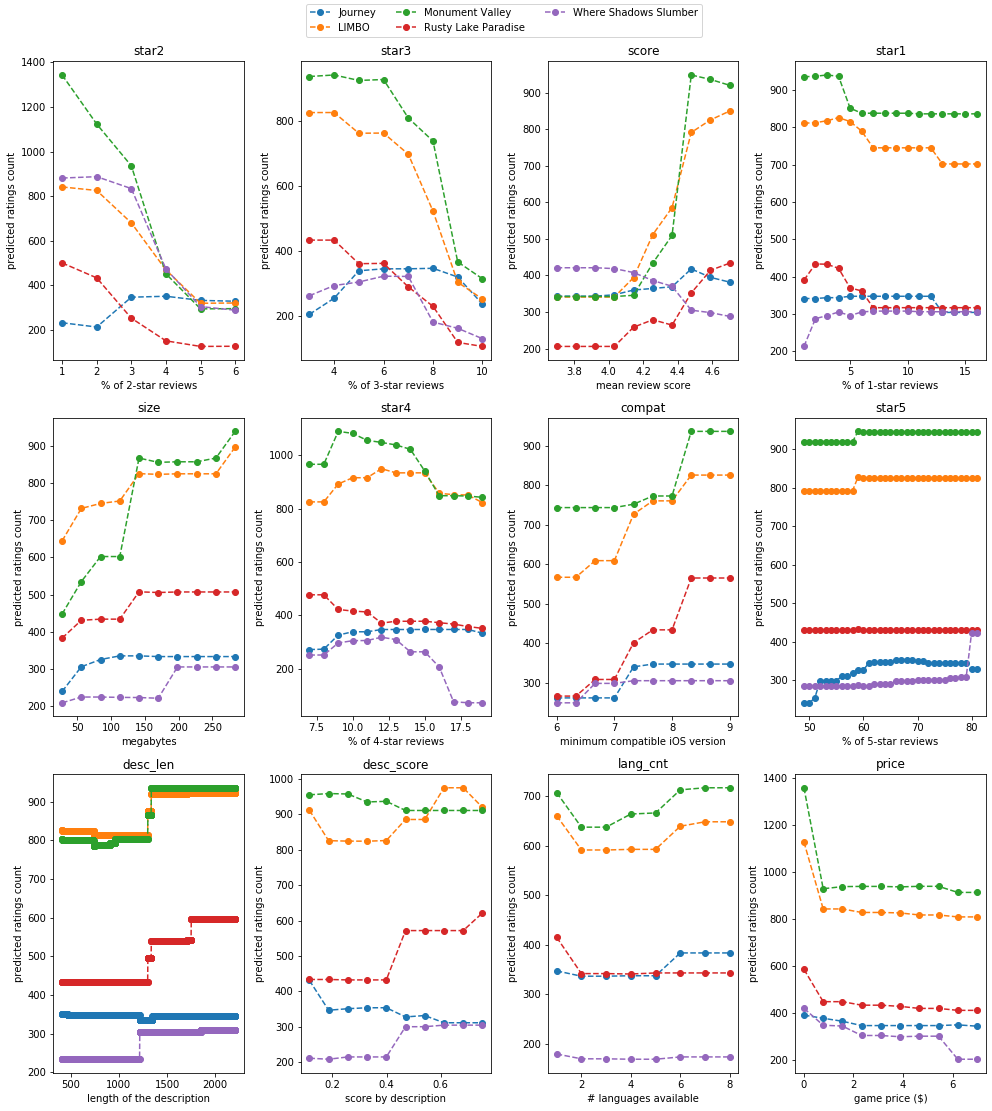

In [33]:
fig, axs = plt.subplots(3,4, figsize=(14, 15))
axs = axs.flatten()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# numerical features to test
star_feats = ['star2', 'star3', 'score', 'star1', 'size', 'star4','compat',
              'star5', 'desc_len','desc_score','lang_cnt','price']

# features of float type (rest are integers)
float_feats = ['size',
               'score',
               'compat',
               'desc_score',
               'price']

# xlabels to add based on feature being plotted
feats_xlabel = ['% of 2-star reviews', '% of 3-star reviews','mean review score', '% of 1-star reviews',
                'megabytes', '% of 4-star reviews', 'minimum compatible iOS version', '% of 5-star reviews',
                'length of the description', 'score by description','# languages available','game price ($)'
               ]
non_trainable_feat = ['nrating','title','author','nrating_cut','list_rank','processed_stem','desc']

# loop through each feature and produce a subplot
for feat_ind, feat in enumerate(star_feats):
    
    # isolate predictor variables to input in model
    ex_feat = ex.drop(columns=non_trainable_feat)
    
    # if feature is float type, test a range of values that lie in between the 15th and 85th percentiles 
    # (in terms of frequency of occurance)
    if feat in float_feats: 
        low_bnd = apps[[feat]].quantile(q=0.15, axis=0).item()
        up_bnd = apps[[feat]].quantile(q=0.85, axis=0).item()
        
        # price is heavily skewed; if we consider only titles that lie in the 15-85th percentile range, they would all have a price of $0.00
        # consequently, we will consider all but the most extreme outliers in price
        if feat == 'price':
            low_bnd = apps[[feat]].quantile(q=0.01, axis=0).item()
            up_bnd = apps[[feat]].quantile(q=0.99, axis=0).item()
        
        # for float types, we plot equispaced points between the percentile range described above
        x_rng = np.linspace(low_bnd, up_bnd, num=10)
    
    # if feature is integer type, likewise test values between the 15th and 85th percentile
    # difference from float is that we test all integer values within the prescribed range
    else:
        low_bnd = apps[[feat]].quantile(q=0.15, axis=0).item()
        up_bnd = apps[[feat]].quantile(q=0.85, axis=0).item()
        x_rng = list(range(int(low_bnd), int(up_bnd)))

    # preallocate variable that will contain predicted number of ratings 
    predictions = np.zeros((len(x_rng), len(ex_feat)))

    # calculate predictions for example games
    for ind, val in enumerate(x_rng):
        ex_feat[feat] = val
        predictions[ind,:] = GBR_grid.best_estimator_.predict(ex_feat)
    
    # plotting code
    fig.tight_layout()
    axs[feat_ind].plot(x_rng, predictions, linestyle='--', marker='o')
    axs[feat_ind].set_title(feat)
    axs[feat_ind].set_ylabel('predicted ratings count')
    axs[feat_ind].set_xlabel(feats_xlabel[feat_ind])
    
fig.legend(ex_summary['title'].tolist(), 
           loc='upper center', 
           ncol=3,
           bbox_to_anchor=(0.5, 1.03))

## Important Categorical Features

Now, we can look at key categorical features that was identified above. The categorical features are editor's choice, Korean language, in-app purchases, and subscription. 

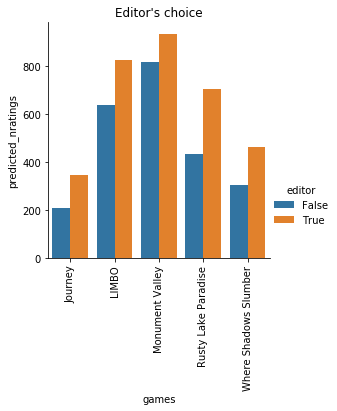

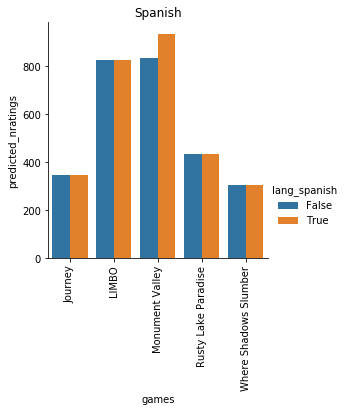

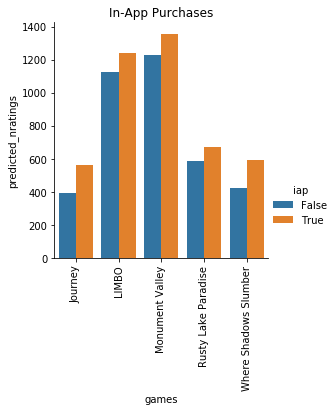

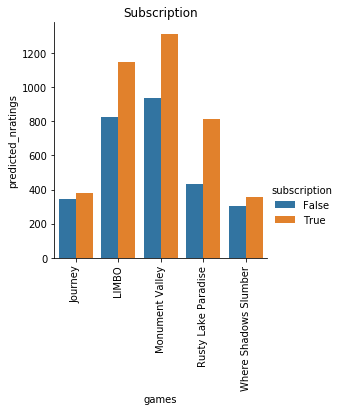

In [34]:
import seaborn as sns

# isolate predictor variables to input in model
bar_data = ex.drop(columns=non_trainable_feat)

# categorical features to test
cat_feat = ['editor', 'lang_spanish', 'iap','subscription']

# titles for subplots
bar_title = ['Editor\'s choice', 'Spanish', 'In-App Purchases','Subscription']

# loop through each feature and generate a subplot
for feat, title in zip(cat_feat, bar_title):
    
    # preallocate DataFrame containing predictions
    bar_data_pred = pd.DataFrame()
    
    # set tested feature to false for all example games
    bar_data_false = bar_data.copy()
    bar_data_false[feat] = False
    
    # set tested feature to true for all example games
    bar_data_true = bar_data.copy()
    bar_data_true[feat] = True
    
    # combine 'false' and 'true' versions
    bar_data_pred = bar_data_true.append(bar_data_false)
    
    # almost all games with in-app purchases are free
    # for this specific feature we also change the price to 0.00
    if feat == 'iap':
        bar_data_pred['price'] = 0.00

    # calculate predictions for example games
    bar_data_pred['predicted_nratings'] = GBR_grid.best_estimator_.predict(bar_data_pred)
    
    # add game titles to DataFrame (in proper order)
    # note that the list of titles has to be repeated
    # one set for feature set to True, another for the feature set to False
    bar_data_pred['games'] = 2 * ex_summary['title'].tolist()

    # plotting code
    g = sns.catplot(x='games', y='predicted_nratings', hue=feat, 
            data=bar_data_pred, kind='bar', height=4)
    
    plt.title(title)
    g.set_xticklabels(rotation=90)

# Business Recommendations
## Overall recommendations
In general, the overall recommendations follow the previous recommendations. This project recommends the following:
- **Create in-app purchase options to increase number of ratings.** The model strongly predicts that the increase in in-app purchase can increase the rating. Surprisingly, numerical features did not contribute to noticeable increase in number of ratings for WSS. Previous recommendation suggested allowing users to play upfront levels of WSS for free and purchasing later levels. This analysis agrees with the previous recommendation. In addition to allowing users to buy levels, we can allow users to buy "hints" to help them guide through the level. 

- **Consider revenue through advertisements.** Alternatively, Game Revenant can release the game for free but include advertisements to generate revenue. Game Revenant can allow no-ad version if users decide to buy the game. Increasing the number of ratings is the most important steps the Game Revenant should take to increase visibility. Revenue through in-app purchase and advertisement is aligned with top games and will likely to be the future of mobile gaming industry based on teh trend that we observed in this analysis. On the other hand, subscription did not increase the number of ratings; based on the game play of WSS, subscription model is not recommended.  

- **Strive for Editor's choice.** The model predicts that Editor's choice can increase the number of ratings across all games. How Editor's choice is selected is not as well-known, except that free or paid apps is reviewed by professional App Store curators. Given the quality of the WSS, crafting a convincing pitch that outlines unique features of the game is recommended. Additionally, it is important to keep the app up-to-date and consider compatibility as one of the important features as it was determined in this project.  (https://clearbridgemobile.com/top-10-ways-to-get-your-app-featured-in-the-app-store/). Many Editor's Choice games are free, so changing the business strategy to allow in-app purchases instead charging the game upfront can help WSS be selected as Editor's Choice. 

## Model limitations 

Again, the largest limitation is that the model assumes that the number of ratings a game receives is strongly correlated with the actual number of downloads. In addition, some variables are innately related to each other and not completely independent (eg, score feature is related to star 5-1). Decreasing the number of features in the future can improve the model performance. 

Ultimately, consumer behavior needs to complement the analysis above to make actionable business recommendations. While free games perform better in number of ratings, it is unclear if these games are profitable. Even with in-app purchases, in-app purchases may not lead to increase in revenue, and the recommendations above need to be taken with caution.
